## Network Constuction
#### This notebook will be used to construct the macrophage protein interaction network from data collected from various protein databases.

### Overview:
1. First we have to build the Macrophage DataFrame using datasets from (APID, UniProt, and Atlas Proteins)
2. Once we have the DataFrame built we can then build the protein interaction tuples that Networkx uses to represent edges between proteins.
3. We can pull out important *attributes* that will be used later on when we have built the Network. We can use the *attributes* to color and visualize our our communities within our network. 
4. We need to combine 2 Mtb databases (Phisto & HPIDB). We will pull out the Mtb to Human protein interactions into their appropriate tuples. Once we have the tuples we will run the human proteins against the Macrophage dataframe to only pull out the interactions that are present within the Macrophages. (Since we are only looking at Macrophage data at the moment)
5. Now that we have the Macrophage edges and the Mtb-Macrophage edges we can develop two separate networks. 
    - Macrophage Network (Healthy)
    - Mtb-Macrophage Network (Diseased)
6. Now that we have developed these two networks we can color by attributes and create visually appealing graphs. We can also check to see the base differences between these graphs. (Using Graphlet Kernels)
7. After we have our base statistics we will run Community detection algorithms on the two networks and see how they differ.

In [1]:
import pandas as pd
import numpy as np

In [2]:
#Load APID data:
APID_df = pd.read_csv("../Data/APID_human_binary.txt", sep='\t', header=0)

#examine data
APID_df

,InteractionID,UniprotID_A,UniprotName_A,GeneName_A,UniprotID_B,UniprotName_B,GeneName_B,ExpEvidences,Methods,Publications,3DStructures,CurationEvents
0,1495672,A0A024R0Y4,A0A024R0Y4_HUMAN,TADA2A,Q8WWY3,PRP31_HUMAN,PRPF31,1,3,1,0,3
1,1591599,A0A024R4B0,A0A024R4B0_HUMAN,SPATA3,O15354,GPR37_HUMAN,GPR37,1,3,1,0,3
2,1532709,A0A024R4Q5,A0A024R4Q5_HUMAN,TFPT,Q96D03,DDT4L_HUMAN,DDIT4L,1,2,1,0,4
3,1532710,A0A024R4Q5,A0A024R4Q5_HUMAN,TFPT,P51911,CNN1_HUMAN,CNN1,1,2,1,0,4
4,1714250,A0A024R6G0,A0A024R6G0_HUMAN,TCL6,P50222,MEOX2_HUMAN,MEOX2,1,3,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
154950,1275834,A0A6L7H3Q9,A0A6L7H3Q9_BACAN,GBAA_2340,Q9Y6X8,ZHX2_HUMAN,ZHX2,1,1,1,0,1
154951,1275836,A0A0F7RKT3,A0A0F7RKT3_BACAN,yobO,Q9Y6X8,ZHX2_HUMAN,ZHX2,1,1,1,0,1
154952,1279160,A0A4Y1WE58,A0A4Y1WE58_BACAN,GBAA_1094,Q9Y6X8,ZHX2_HUMAN,ZHX2,1,1,1,0,1
154953,1279161,A0A6H3AES4,A0A6H3AES4_BACAN,GBAA_2380,Q9Y6X8,ZHX2_HUMAN,ZHX2,1,1,1,0,1


In [3]:
#Load Uniprot data
Uniprot_df = pd.read_csv("../Data/uniprot-homo+sapiens.tab.gz", sep='\t', header=0, compression='gzip', low_memory=False)

#examine data
Uniprot_df

,Entry,Entry name,Status,Protein names,Gene names,Organism,Gene ontology (biological process),Gene ontology (GO),Gene ontology (cellular component),Gene ontology IDs,Gene ontology (molecular function),Intramembrane,Subcellular location [CC],Transmembrane,Topological domain,Pathway
0,Q53XC5,Q53XC5_HUMAN,unreviewed,Bone morphogenetic protein 4 (Bone morphogenet...,BMP4 hCG_20967,Homo sapiens (Human),anterior/posterior axis specification [GO:0009...,extracellular space [GO:0005615]; growth facto...,extracellular space [GO:0005615],GO:0000122; GO:0001649; GO:0001658; GO:0001759...,growth factor activity [GO:0008083]; heparin b...,NaN,NaN,NaN,NaN,NaN
1,A8K571,A8K571_HUMAN,unreviewed,Bone morphogenetic protein 7 (Osteogenic prote...,BMP7 hCG_40100,Homo sapiens (Human),allantois development [GO:1905069]; axon guida...,collagen-containing extracellular matrix [GO:0...,collagen-containing extracellular matrix [GO:0...,GO:0001657; GO:0001707; GO:0003272; GO:0003344...,growth factor activity [GO:0008083]; heparin b...,NaN,NaN,NaN,NaN,NaN
2,A8K660,A8K660_HUMAN,unreviewed,"Adiponectin (Adiponectin, C1Q and collagen dom...",ADIPOQ hCG_1784052,Homo sapiens (Human),brown fat cell differentiation [GO:0050873]; c...,collagen trimer [GO:0005581]; endoplasmic reti...,collagen trimer [GO:0005581]; endoplasmic reti...,GO:0001666; GO:0005179; GO:0005581; GO:0005615...,hormone activity [GO:0005179]; identical prote...,NaN,NaN,NaN,NaN,NaN
3,Q5U0J5,Q5U0J5_HUMAN,unreviewed,cAMP responsive element binding protein 1 (cAM...,CREB1 hCG_15208,Homo sapiens (Human),aging [GO:0007568]; axonogenesis [GO:0007409];...,ATF4-CREB1 transcription factor complex [GO:19...,ATF4-CREB1 transcription factor complex [GO:19...,GO:0000785; GO:0001225; GO:0001228; GO:0001666...,arrestin family protein binding [GO:1990763]; ...,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000256|ARB...,NaN,NaN,NaN
4,Q5TCX1,Q5TCX1_HUMAN,unreviewed,Triggering receptor expressed on myeloid cells...,TREM2,Homo sapiens (Human),amyloid-beta clearance [GO:0097242]; apoptotic...,integral component of plasma membrane [GO:0005...,integral component of plasma membrane [GO:0005...,GO:0001530; GO:0001934; GO:0002282; GO:0002931...,lipopolysaccharide binding [GO:0001530]; lipot...,NaN,NaN,"TRANSMEM 175..197; /note=""Helical""; /evidenc...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697039,A0A1U9ZCU9,A0A1U9ZCU9_HHV2,unreviewed,Envelope glycoprotein C,UL44,Human herpesvirus 2 (HHV-2) (Human herpes simp...,adhesion receptor-mediated virion attachment t...,integral component of membrane [GO:0016021]; v...,integral component of membrane [GO:0016021]; v...,GO:0016021; GO:0019031; GO:0039573; GO:0046718...,NaN,NaN,SUBCELLULAR LOCATION: Membrane {ECO:0000256|AR...,NaN,NaN,NaN
1697040,A0A481TU19,A0A481TU19_HHV2,unreviewed,Uncharacterized protein,NaN,Human herpesvirus 2 (HHV-2) (Human herpes simp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1697041,A0A481TRG4,A0A481TRG4_HHV2,unreviewed,UL46,NaN,Human herpesvirus 2 (HHV-2) (Human herpes simp...,"regulation of transcription, DNA-templated [GO...",virion [GO:0019012]; regulation of transcripti...,virion [GO:0019012],GO:0006355; GO:0019012,NaN,NaN,NaN,NaN,NaN,NaN
1697042,A0A7G7P0R5,A0A7G7P0R5_HHV2,unreviewed,Envelope glycoprotein C,NaN,Human herpesvirus 2 (HHV-2) (Human herpes simp...,adhesion receptor-mediated virion attachment t...,integral component of membrane [GO:0016021]; v...,integral component of membrane [GO:0016021]; v...,GO:0016021; GO:0039573; GO:0046718; GO:0055036...,NaN,NaN,SUBCELLULAR LOCATION: Membrane {ECO:0000256|AR...,"TRANSMEM 448..470; /note=""Helical""; /evidenc...",NaN,NaN


Now that we have all of the dataframes imported we can combine the APID and UniProt on like columns:
- Columns: `UniprotID_{A|B}` DF: APID
- Columns: `Entry` DF: UniProt

In [4]:
#Merge Uniprot Data with APID data
Merged_A = pd.merge(APID_df, right=Uniprot_df, how='inner', left_on="UniprotID_A", right_on="Entry")
Merged_AB = pd.merge(Merged_A, right=Uniprot_df, how='inner', left_on="UniprotID_B", right_on="Entry", suffixes=("_A","_B"))

#examine
Merged_AB


,InteractionID,UniprotID_A,UniprotName_A,GeneName_A,UniprotID_B,UniprotName_B,GeneName_B,ExpEvidences,Methods,Publications,...,Gene ontology (biological process)_B,Gene ontology (GO)_B,Gene ontology (cellular component)_B,Gene ontology IDs_B,Gene ontology (molecular function)_B,Intramembrane_B,Subcellular location [CC]_B,Transmembrane_B,Topological domain_B,Pathway_B
0,1495672,A0A024R0Y4,A0A024R0Y4_HUMAN,TADA2A,Q8WWY3,PRP31_HUMAN,PRPF31,1,3,1,...,"mRNA splicing, via spliceosome [GO:0000398]; r...",Cajal body [GO:0015030]; MLL1 complex [GO:0071...,Cajal body [GO:0015030]; MLL1 complex [GO:0071...,GO:0000244; GO:0000398; GO:0003723; GO:0005634...,identical protein binding [GO:0042802]; ribonu...,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,NaN
1,1675028,A1L4K1,FSD2_HUMAN,FSD2,Q8WWY3,PRP31_HUMAN,PRPF31,1,1,1,...,"mRNA splicing, via spliceosome [GO:0000398]; r...",Cajal body [GO:0015030]; MLL1 complex [GO:0071...,Cajal body [GO:0015030]; MLL1 complex [GO:0071...,GO:0000244; GO:0000398; GO:0003723; GO:0005634...,identical protein binding [GO:0042802]; ribonu...,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,NaN
2,1694417,A6NEM1,GG6L9_HUMAN,GOLGA6L9,Q8WWY3,PRP31_HUMAN,PRPF31,1,1,1,...,"mRNA splicing, via spliceosome [GO:0000398]; r...",Cajal body [GO:0015030]; MLL1 complex [GO:0071...,Cajal body [GO:0015030]; MLL1 complex [GO:0071...,GO:0000244; GO:0000398; GO:0003723; GO:0005634...,identical protein binding [GO:0042802]; ribonu...,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,NaN
3,1677191,A8MQ03,CRTP1_HUMAN,CYSRT1,Q8WWY3,PRP31_HUMAN,PRPF31,1,1,1,...,"mRNA splicing, via spliceosome [GO:0000398]; r...",Cajal body [GO:0015030]; MLL1 complex [GO:0071...,Cajal body [GO:0015030]; MLL1 complex [GO:0071...,GO:0000244; GO:0000398; GO:0003723; GO:0005634...,identical protein binding [GO:0042802]; ribonu...,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,NaN
4,1532683,O14641,DVL2_HUMAN,DVL2,Q8WWY3,PRP31_HUMAN,PRPF31,1,3,1,...,"mRNA splicing, via spliceosome [GO:0000398]; r...",Cajal body [GO:0015030]; MLL1 complex [GO:0071...,Cajal body [GO:0015030]; MLL1 complex [GO:0071...,GO:0000244; GO:0000398; GO:0003723; GO:0005634...,identical protein binding [GO:0042802]; ribonu...,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139730,1378134,P0C706,CVC2_EBVG,CVC2,Q6FH22,Q6FH22_HUMAN,EFEMP2,1,1,1,...,elastic fiber assembly [GO:0048251],extracellular space [GO:0005615]; calcium ion ...,extracellular space [GO:0005615],GO:0005509; GO:0005615; GO:0048251,calcium ion binding [GO:0005509],NaN,NaN,NaN,NaN,NaN
139731,1378183,Q3KSU1,ICP27_EBVG,BSLF2,Q68DS7,Q68DS7_HUMAN,DKFZp686E07254,1,1,1,...,NaN,DNA binding [GO:0003677]; metal ion binding [G...,NaN,GO:0003677; GO:0046872,DNA binding [GO:0003677]; metal ion binding [G...,NaN,NaN,NaN,NaN,NaN
139732,1396956,Q2I360,Q2I360_HBV,C,Q6NW24,Q6NW24_HUMAN,PDCD2,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139733,1378079,P0CK53,CEP2_EBVB9,BGLF2,Q8TF72,SHRM3_HUMAN,SHROOM3,1,1,1,...,actin filament organization [GO:0007015]; apic...,adherens junction [GO:0005912]; apical junctio...,adherens junction [GO:0005912]; apical junctio...,GO:0000902; GO:0001843; GO:0002064; GO:0005856...,actin filament binding [GO:0051015],NaN,"SUBCELLULAR LOCATION: Cell junction, adherens ...",NaN,NaN,NaN


In [5]:
#examine column names
Merged_AB.columns

Index(['InteractionID', 'UniprotID_A', 'UniprotName_A', 'GeneName_A',
       'UniprotID_B', 'UniprotName_B', 'GeneName_B', 'ExpEvidences', 'Methods',
       'Publications', '3DStructures', 'CurationEvents', 'Entry_A',
       'Entry name_A', 'Status_A', 'Protein names_A', 'Gene names_A',
       'Organism_A', 'Gene ontology (biological process)_A',
       'Gene ontology (GO)_A', 'Gene ontology (cellular component)_A',
       'Gene ontology IDs_A', 'Gene ontology (molecular function)_A',
       'Intramembrane_A', 'Subcellular location [CC]_A', 'Transmembrane_A',
       'Topological domain_A', 'Pathway_A', 'Entry_B', 'Entry name_B',
       'Status_B', 'Protein names_B', 'Gene names_B', 'Organism_B',
       'Gene ontology (biological process)_B', 'Gene ontology (GO)_B',
       'Gene ontology (cellular component)_B', 'Gene ontology IDs_B',
       'Gene ontology (molecular function)_B', 'Intramembrane_B',
       'Subcellular location [CC]_B', 'Transmembrane_B',
       'Topological domain_B', 

### Subsetting the Merged Dataframe

After combining information from the APID and Uniprot databases into one dataframe, we want to filter it to only include proteins expressed in macrophages, the cell that tuberculosis infects. We filtered the list using the Protein Atlas Database that contains a list of all proteins expressed in macrophages. 

Literature on Mtb infection:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3867229/

In [6]:
#Load Human Protein Atlas Macrophage Data
HPA_df = pd.read_csv("../Data/cell_type_category_rna_Macrophages_Cell.tsv", sep ='\t', header=0)

#removes rows with NA's in Uniprot column
HPA_df = HPA_df[HPA_df['Uniprot'].notna()]

#examine data
HPA_df

,Gene,Gene synonym,Ensembl,Gene description,Uniprot,Chromosome,Position,Protein class,Biological process,Molecular function,...,Single Cell Type RNA - Rod photoreceptor cells [NX],Single Cell Type RNA - Sertoli cells [NX],Single Cell Type RNA - Smooth muscle cells [NX],Single Cell Type RNA - Spermatocytes [NX],Single Cell Type RNA - Spermatogonia [NX],Single Cell Type RNA - Suprabasal keratinocytes [NX],Single Cell Type RNA - Syncytiotrophoblasts [NX],Single Cell Type RNA - T-cells [NX],Single Cell Type RNA - Undifferentiated cells [NX],Single Cell Type RNA - Urothelial cells [NX]
0,CATSPER1,CATSPER,ENSG00000175294,Cation channel sperm associated 1,Q8NEC5,11,66016752-66026517,"Disease related genes, Predicted membrane prot...","Calcium transport, Differentiation, Ion transp...","Calcium channel, Developmental protein, Ion ch...",...,0.0,0.0,0.1,0.5,0.4,0.3,0.3,4.3,0.0,0.3
1,HIST1H1B,"H1.5, H1b, H1F5, H1s-3",ENSG00000184357,Histone cluster 1 H1 family member b,P16401,6,27866849-27867529,"Plasma proteins, Predicted intracellular proteins",NaN,DNA-binding,...,0.0,0.0,0.0,0.1,1.2,0.0,0.6,1.8,0.9,0.1
2,FCER1A,FCE1A,ENSG00000179639,Fc fragment of IgE receptor Ia,P12319,1,159289714-159308224,"FDA approved drug targets, Predicted membrane ...",NaN,"IgE-binding protein, Receptor",...,0.0,12.9,0.6,0.0,0.2,29.7,0.0,0.0,0.0,0.0
3,ADAMDEC1,M12.219,ENSG00000134028,ADAM like decysin 1,O15204,8,24384285-24406013,"Plasma proteins, Predicted intracellular prote...",NaN,"Hydrolase, Metalloprotease, Protease",...,0.0,0.0,0.0,0.0,0.0,0.3,0.1,0.0,0.0,0.0
4,STAC3,MGC2793,ENSG00000185482,SH3 and cysteine rich domain 3,Q96MF2,12,57243453-57251193,"Disease related genes, Predicted intracellular...",NaN,NaN,...,1.9,0.0,0.3,2.4,1.1,0.3,1.1,1.3,1.1,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,VSIG4,Z39IG,ENSG00000155659,V-set and immunoglobulin domain containing 4,Q9Y279,X,66021738-66040125,"Plasma proteins, Predicted membrane proteins","Complement alternate pathway, Immunity, Innate...",NaN,...,0.0,6.5,0.2,0.2,0.9,1.5,10.3,0.0,0.0,0.2
403,WAS,"IMD2, THC, WASP, WASPA",ENSG00000015285,Wiskott-Aldrich syndrome,P42768,X,48676596-48691427,"Cancer-related genes, Disease related genes, P...",NaN,NaN,...,0.0,0.0,0.6,1.4,1.1,1.3,1.1,87.0,0.0,0.1
404,WDFY4,"C10orf64, Em:AC060234.3, FLJ45748, KIAA1607",ENSG00000128815,WDFY family member 4,Q6ZS81,10,48684876-48982956,"Predicted intracellular proteins, Predicted me...",Autophagy,NaN,...,0.0,0.0,0.4,0.6,0.6,0.3,0.2,0.0,0.0,0.0
405,ZEB2,"KIAA0569, SIP-1, SIP1, ZFHX1B",ENSG00000169554,Zinc finger E-box binding homeobox 2,O60315,2,144364364-144524583,"Disease related genes, Predicted intracellular...","Transcription, Transcription regulation","DNA-binding, Repressor",...,8.6,181.1,167.0,2.3,7.0,17.1,3.9,99.2,0.0,2.0


In [7]:
#Filter merged APID data to only include those entries corresponding to proteins found in Macrophages
protein_list = HPA_df['Uniprot']

Check_list = Merged_AB.UniprotID_A.isin(protein_list)| Merged_AB.UniprotID_B.isin(protein_list)

filtered_mergedAB_df = Merged_AB[Check_list] 

#examine
filtered_mergedAB_df

,InteractionID,UniprotID_A,UniprotName_A,GeneName_A,UniprotID_B,UniprotName_B,GeneName_B,ExpEvidences,Methods,Publications,...,Gene ontology (biological process)_B,Gene ontology (GO)_B,Gene ontology (cellular component)_B,Gene ontology IDs_B,Gene ontology (molecular function)_B,Intramembrane_B,Subcellular location [CC]_B,Transmembrane_B,Topological domain_B,Pathway_B
9,1495411,O43586,PPIP1_HUMAN,PSTPIP1,Q8WWY3,PRP31_HUMAN,PRPF31,3,5,3,...,"mRNA splicing, via spliceosome [GO:0000398]; r...",Cajal body [GO:0015030]; MLL1 complex [GO:0071...,Cajal body [GO:0015030]; MLL1 complex [GO:0071...,GO:0000244; GO:0000398; GO:0003723; GO:0005634...,identical protein binding [GO:0042802]; ribonu...,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,NaN
146,1591593,Q02930,CREB5_HUMAN,CREB5,O15354,GPR37_HUMAN,GPR37,1,3,1,...,adenylate cyclase-inhibiting G protein-coupled...,cell surface [GO:0009986]; cytoplasm [GO:00057...,cell surface [GO:0009986]; cytoplasm [GO:00057...,GO:0000151; GO:0004930; GO:0005737; GO:0005783...,G protein-coupled peptide receptor activity [G...,NaN,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,"TRANSMEM 266..286; /note=""Helical; Name=1""; ...","TOPO_DOM 27..265; /note=""Extracellular""; /ev...",NaN
245,2175074,P09917,LOX5_HUMAN,ALOX5,P50222,MEOX2_HUMAN,MEOX2,1,1,1,...,angiogenesis [GO:0001525]; blood circulation [...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,GO:0000785; GO:0000978; GO:0000981; GO:0001228...,"DNA-binding transcription activator activity, ...",NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,NaN
345,1706672,Q8NF50,DOCK8_HUMAN,DOCK8,P50222,MEOX2_HUMAN,MEOX2,2,4,2,...,angiogenesis [GO:0001525]; blood circulation [...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,GO:0000785; GO:0000978; GO:0000981; GO:0001228...,"DNA-binding transcription activator activity, ...",NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,NaN
389,1709225,Q9HBI0,PARVG_HUMAN,PARVG,P50222,MEOX2_HUMAN,MEOX2,2,4,2,...,angiogenesis [GO:0001525]; blood circulation [...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,GO:0000785; GO:0000978; GO:0000981; GO:0001228...,"DNA-binding transcription activator activity, ...",NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139615,1216972,P24837,VE7_HPV39,E7,Q16831,UPP1_HUMAN,UPP1,1,1,1,...,cellular response to glucose starvation [GO:00...,cytosol [GO:0005829]; nucleoplasm [GO:0005654]...,cytosol [GO:0005829]; nucleoplasm [GO:0005654],GO:0004850; GO:0005654; GO:0005829; GO:0006139...,deoxyuridine phosphorylase activity [GO:004784...,NaN,NaN,NaN,NaN,PATHWAY: Pyrimidine metabolism; UMP biosynthes...
139616,1216827,Q84292,VE7_HPV6A,E7,Q16831,UPP1_HUMAN,UPP1,1,1,1,...,cellular response to glucose starvation [GO:00...,cytosol [GO:0005829]; nucleoplasm [GO:0005654]...,cytosol [GO:0005829]; nucleoplasm [GO:0005654],GO:0004850; GO:0005654; GO:0005829; GO:0006139...,deoxyuridine phosphorylase activity [GO:004784...,NaN,NaN,NaN,NaN,PATHWAY: Pyrimidine metabolism; UMP biosynthes...
139624,2171319,P0C6X7,R1AB_CVHSA,rep,Q8NEQ5,CA162_HUMAN,C1orf162,1,1,1,...,NaN,integral component of membrane [GO:0016021],integral component of membrane [GO:0016021],GO:0016021,NaN,NaN,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,"TRANSMEM 41..61; /note=""Helical""; /evidence=...",NaN,NaN
139689,2108647,P03126,VE6_HPV16,E6,Q8WZ60,KLHL6_HUMAN,KLHL6,1,1,1,...,B cell receptor signaling pathway [GO:0050853]...,B cell receptor signaling pathway [GO:0050853]...,NaN,GO:0002467; GO:0050853,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Removing Entries where proteins bind to themselves:
Check_identical = filtered_mergedAB_df.UniprotID_A != filtered_mergedAB_df.UniprotID_B
final_merged = filtered_mergedAB_df[Check_identical]

In [9]:
#examine data
final_merged

,InteractionID,UniprotID_A,UniprotName_A,GeneName_A,UniprotID_B,UniprotName_B,GeneName_B,ExpEvidences,Methods,Publications,...,Gene ontology (biological process)_B,Gene ontology (GO)_B,Gene ontology (cellular component)_B,Gene ontology IDs_B,Gene ontology (molecular function)_B,Intramembrane_B,Subcellular location [CC]_B,Transmembrane_B,Topological domain_B,Pathway_B
9,1495411,O43586,PPIP1_HUMAN,PSTPIP1,Q8WWY3,PRP31_HUMAN,PRPF31,3,5,3,...,"mRNA splicing, via spliceosome [GO:0000398]; r...",Cajal body [GO:0015030]; MLL1 complex [GO:0071...,Cajal body [GO:0015030]; MLL1 complex [GO:0071...,GO:0000244; GO:0000398; GO:0003723; GO:0005634...,identical protein binding [GO:0042802]; ribonu...,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,NaN
146,1591593,Q02930,CREB5_HUMAN,CREB5,O15354,GPR37_HUMAN,GPR37,1,3,1,...,adenylate cyclase-inhibiting G protein-coupled...,cell surface [GO:0009986]; cytoplasm [GO:00057...,cell surface [GO:0009986]; cytoplasm [GO:00057...,GO:0000151; GO:0004930; GO:0005737; GO:0005783...,G protein-coupled peptide receptor activity [G...,NaN,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,"TRANSMEM 266..286; /note=""Helical; Name=1""; ...","TOPO_DOM 27..265; /note=""Extracellular""; /ev...",NaN
245,2175074,P09917,LOX5_HUMAN,ALOX5,P50222,MEOX2_HUMAN,MEOX2,1,1,1,...,angiogenesis [GO:0001525]; blood circulation [...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,GO:0000785; GO:0000978; GO:0000981; GO:0001228...,"DNA-binding transcription activator activity, ...",NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,NaN
345,1706672,Q8NF50,DOCK8_HUMAN,DOCK8,P50222,MEOX2_HUMAN,MEOX2,2,4,2,...,angiogenesis [GO:0001525]; blood circulation [...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,GO:0000785; GO:0000978; GO:0000981; GO:0001228...,"DNA-binding transcription activator activity, ...",NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,NaN
389,1709225,Q9HBI0,PARVG_HUMAN,PARVG,P50222,MEOX2_HUMAN,MEOX2,2,4,2,...,angiogenesis [GO:0001525]; blood circulation [...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,GO:0000785; GO:0000978; GO:0000981; GO:0001228...,"DNA-binding transcription activator activity, ...",NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139615,1216972,P24837,VE7_HPV39,E7,Q16831,UPP1_HUMAN,UPP1,1,1,1,...,cellular response to glucose starvation [GO:00...,cytosol [GO:0005829]; nucleoplasm [GO:0005654]...,cytosol [GO:0005829]; nucleoplasm [GO:0005654],GO:0004850; GO:0005654; GO:0005829; GO:0006139...,deoxyuridine phosphorylase activity [GO:004784...,NaN,NaN,NaN,NaN,PATHWAY: Pyrimidine metabolism; UMP biosynthes...
139616,1216827,Q84292,VE7_HPV6A,E7,Q16831,UPP1_HUMAN,UPP1,1,1,1,...,cellular response to glucose starvation [GO:00...,cytosol [GO:0005829]; nucleoplasm [GO:0005654]...,cytosol [GO:0005829]; nucleoplasm [GO:0005654],GO:0004850; GO:0005654; GO:0005829; GO:0006139...,deoxyuridine phosphorylase activity [GO:004784...,NaN,NaN,NaN,NaN,PATHWAY: Pyrimidine metabolism; UMP biosynthes...
139624,2171319,P0C6X7,R1AB_CVHSA,rep,Q8NEQ5,CA162_HUMAN,C1orf162,1,1,1,...,NaN,integral component of membrane [GO:0016021],integral component of membrane [GO:0016021],GO:0016021,NaN,NaN,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,"TRANSMEM 41..61; /note=""Helical""; /evidence=...",NaN,NaN
139689,2108647,P03126,VE6_HPV16,E6,Q8WZ60,KLHL6_HUMAN,KLHL6,1,1,1,...,B cell receptor signaling pathway [GO:0050853]...,B cell receptor signaling pathway [GO:0050853]...,NaN,GO:0002467; GO:0050853,NaN,NaN,NaN,NaN,NaN,NaN


# Cleaning the attribute data
Next we will clean up the attributes. Looking at the dataframe, these columns include messy labels which makes it difficult to compare and analyze downstream.

In [10]:
import re

#Replacing all Nan entries with "unknown"
final_merged = final_merged.replace(np.nan, 'Unknown', regex=True)

#Cleaning up subcellular location attribute

location_A_working = []
#Rename location information as first location seen
for row in final_merged["Subcellular location [CC]_A"]:
    if row == "Unknown":
        location_A_working.append(row)
    else:
        location0 = row.split(':')[1]
        location1 = re.split('[{,.;]', location0)[0]
        location2 = location1[1:]
        if "[" in location2:
            location3 = re.split(':',row)[2]
            location4 = re.split('[.,;]',location3)[0]
            location5 = location4[1:]
            try:
                location6 = location5.split('{')[0]
                location_A_working.append(str(location6))
            except:
                 location_A_working.append(str(location5))
        else:
             location_A_working.append(str(location2))
            

location_A = []      
for i in location_A_working:
    item = i.strip()
    if ' {' not in item:
        location_A.append(item)
    else:
        var = i.split("{")[0]
        location_A.append(var)
# for i in location_A:
#     print(i)


#Perform the same for location B:

location_B_working = []

for row in final_merged["Subcellular location [CC]_B"]:
    if row == "Unknown":
        location_B_working.append(row)
    else:
        location0 = row.split(':')[1]
        location1 = re.split('[{,.;]', location0)[0]
        location2 = location1[1:]
        if "[" in location2:
            location3 = re.split(':',row)[2]
            location4 = re.split('[.,;]',location3)[0]
            location5 = location4[1:]
            try:
                location6 = location5.split('{')[0]
                location_B_working.append(str(location6))
            except:
                 location_B_working.append(str(location5))
        else:
             location_B_working.append(str(location2))
            

location_B = []      
for i in location_B_working:
    item = i.strip()
    if ' {' not in item:
        location_B.append(item)
    else:
        var = i.split("{")[0]
        location_B.append(var)
# for i in location_B:
#     print(i)
        

In [11]:
#Do the same for GO molecular function

molec_A =[]
for row in final_merged["Gene ontology (molecular function)_A"]:
    if row == "Unknown":
        molec_A.append(row)
    else:
        location0 = row.split('[')[0]
        molec_A.append(location0.strip())
# for i in molec_A:
#     print(i)
    
molec_B =[]
for row in final_merged["Gene ontology (molecular function)_B"]:
    if row == "Unknown":
        molec_B.append(row)
    else:
        location0 = row.split('[')[0]
        molec_B.append(location0.strip())
# for i in molec_B:
#     print(i)

In [12]:
#Do the same for GO cellular component
cell_A =[]
for row in final_merged["Gene ontology (cellular component)_A"]:
    if row == "Unknown":
        cell_A.append(row)
    else:
        location0 = row.split('[')[0]
        cell_A.append(location0.strip())
# for i in molec_A:
#     print(i)
    
cell_B =[]
for row in final_merged["Gene ontology (cellular component)_B"]:
    if row == "Unknown":
        cell_B.append(row)
    else:
        location0 = row.split('[')[0]
        cell_B.append(location0.strip())
# for i in molec_B:
#     print(i)

In [13]:
#Do the same for GO biological process

bio_A =[]
for row in final_merged["Gene ontology (biological process)_A"]:
    if row == "Unknown":
        bio_A.append(row)
    else:
        location0 = row.split('[')[0]
        bio_A.append(location0.strip())
# for i in bio_A:
#     print(i)
    
bio_B =[]
for row in final_merged["Gene ontology (biological process)_B"]:
    if row == "Unknown":
        bio_B.append(row)
    else:
        location0 = row.split('[')[0]
        bio_B.append(location0.strip())
# for i in bio_B:
#     print(i)

In [14]:
#Do the same for intramembrane
intra_A =[]
for row in final_merged["Intramembrane_A"]:
    if row == "NaN":
        intra_A.append(row)
    else:
        location0 = row.split(';')[0]
        intra_A.append(location0.strip())
# for i in intra_A:
#     print(i)
    
intra_B =[]
for row in final_merged["Intramembrane_B"]:
    if row == "NaN":
        intra_B.append(row)
    else:
        location0 = row.split(';')[0]
        intra_B.append(location0.strip())
# for i in intra_B:
#     print(i)

In [15]:
#Do the same for topological domain
topo_A =[]
for row in final_merged["Topological domain_A"]:
    if row == "Unknown":
        topo_A.append(row)
    else:
        location0 = row.split(';')[0]
        topo_A.append(location0.strip())
# for i in topo_A:
#     print(i)
    
topo_B =[]
for row in final_merged["Topological domain_B"]:
    if row == "Unknown":
        topo_B.append(row)
    else:
        location0 = row.split(';')[0]
        topo_B.append(location0.strip())
# for i in topo_B:
#     print(i)

In [16]:
#Do the same for pathway
path_A =[]
for row in final_merged["Pathway_A"]:
    if row == "NaN":
        path_A.append(row)
    else:
        location0 = row.split(';')[0]
        location1 = location0.split(': ')[0]
        path_A.append(location1.strip())
# for i in path_A:
#     print(i)
    
path_B =[]
for row in final_merged["Pathway_B"]:
    if row == "NaN":
        path_B.append(row)
    else:
        location0 = row.split(';')[0]
        location1 = location0.split(': ')[0]
        path_B.append(location0.strip())
# for i in path_B:
#     print(i)

In [17]:
#Create new data frame columns with the refined attribute information

final_merged["Subcellular location [CC]_A"] = location_A
final_merged["Subcellular location [CC]_B"] = location_B

final_merged["Gene ontology (molecular function)_A"] = molec_A
final_merged["Gene ontology (molecular function)_B"] = molec_B

final_merged["Gene ontology (cellular component)_A"] = cell_A
final_merged["Gene ontology (cellular component)_B"] = cell_B

final_merged["Topological domain_A"] = topo_A
final_merged["Topological domain_B"] = topo_B

final_merged["Intramembrane_A"] = intra_A
final_merged["Intramembrane_B"] = intra_B

final_merged["Gene ontology (biological process)_A"] = bio_A
final_merged["Gene ontology (biological process)_B"] = bio_B

final_merged["Pathway_A"] = path_A
final_merged["Pathway_B"] = path_B

#examine data
final_merged


,InteractionID,UniprotID_A,UniprotName_A,GeneName_A,UniprotID_B,UniprotName_B,GeneName_B,ExpEvidences,Methods,Publications,...,Gene ontology (biological process)_B,Gene ontology (GO)_B,Gene ontology (cellular component)_B,Gene ontology IDs_B,Gene ontology (molecular function)_B,Intramembrane_B,Subcellular location [CC]_B,Transmembrane_B,Topological domain_B,Pathway_B
9,1495411,O43586,PPIP1_HUMAN,PSTPIP1,Q8WWY3,PRP31_HUMAN,PRPF31,3,5,3,...,"mRNA splicing, via spliceosome",Cajal body [GO:0015030]; MLL1 complex [GO:0071...,Cajal body,GO:0000244; GO:0000398; GO:0003723; GO:0005634...,identical protein binding,Unknown,Nucleus,Unknown,Unknown,Unknown
146,1591593,Q02930,CREB5_HUMAN,CREB5,O15354,GPR37_HUMAN,GPR37,1,3,1,...,adenylate cyclase-inhibiting G protein-coupled...,cell surface [GO:0009986]; cytoplasm [GO:00057...,cell surface,GO:0000151; GO:0004930; GO:0005737; GO:0005783...,G protein-coupled peptide receptor activity,Unknown,Cell membrane,"TRANSMEM 266..286; /note=""Helical; Name=1""; ...",TOPO_DOM 27..265,Unknown
245,2175074,P09917,LOX5_HUMAN,ALOX5,P50222,MEOX2_HUMAN,MEOX2,1,1,1,...,angiogenesis,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,chromatin,GO:0000785; GO:0000978; GO:0000981; GO:0001228...,"DNA-binding transcription activator activity, ...",Unknown,Nucleus,Unknown,Unknown,Unknown
345,1706672,Q8NF50,DOCK8_HUMAN,DOCK8,P50222,MEOX2_HUMAN,MEOX2,2,4,2,...,angiogenesis,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,chromatin,GO:0000785; GO:0000978; GO:0000981; GO:0001228...,"DNA-binding transcription activator activity, ...",Unknown,Nucleus,Unknown,Unknown,Unknown
389,1709225,Q9HBI0,PARVG_HUMAN,PARVG,P50222,MEOX2_HUMAN,MEOX2,2,4,2,...,angiogenesis,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,chromatin,GO:0000785; GO:0000978; GO:0000981; GO:0001228...,"DNA-binding transcription activator activity, ...",Unknown,Nucleus,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139615,1216972,P24837,VE7_HPV39,E7,Q16831,UPP1_HUMAN,UPP1,1,1,1,...,cellular response to glucose starvation,cytosol [GO:0005829]; nucleoplasm [GO:0005654]...,cytosol,GO:0004850; GO:0005654; GO:0005829; GO:0006139...,deoxyuridine phosphorylase activity,Unknown,Unknown,Unknown,Unknown,PATHWAY: Pyrimidine metabolism
139616,1216827,Q84292,VE7_HPV6A,E7,Q16831,UPP1_HUMAN,UPP1,1,1,1,...,cellular response to glucose starvation,cytosol [GO:0005829]; nucleoplasm [GO:0005654]...,cytosol,GO:0004850; GO:0005654; GO:0005829; GO:0006139...,deoxyuridine phosphorylase activity,Unknown,Unknown,Unknown,Unknown,PATHWAY: Pyrimidine metabolism
139624,2171319,P0C6X7,R1AB_CVHSA,rep,Q8NEQ5,CA162_HUMAN,C1orf162,1,1,1,...,Unknown,integral component of membrane [GO:0016021],integral component of membrane,GO:0016021,Unknown,Unknown,Membrane,"TRANSMEM 41..61; /note=""Helical""; /evidence=...",Unknown,Unknown
139689,2108647,P03126,VE6_HPV16,E6,Q8WZ60,KLHL6_HUMAN,KLHL6,1,1,1,...,B cell receptor signaling pathway,B cell receptor signaling pathway [GO:0050853]...,Unknown,GO:0002467; GO:0050853,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [18]:
#Write Merged and Filtered Dataset to tsv file
#final_merged.to_csv('../Data/APID_human_binary_macrophage.txt', sep='\t')

# Network Assembly
Now that we have all the components, we can use networkx to assemble our network, which is represented a list of tuples, where each tuple represents a pair of interacting proteins. 

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [20]:
#First, we will read in the dataframe we created in the previous step
APID_Macrophage_Interactions = pd.read_csv("../Data/APID_human_binary_macrophage.txt", sep='\t', header=0)

In [21]:
#Constructing the Network

G = nx.Graph(name="Healthy Network")
node_list=[]
edge_list=[]

#Extract Protein IDs for protein A and B in each row of dataframe, adding to master list
for index,row in APID_Macrophage_Interactions.iterrows():
    protA = row["UniprotID_A"]
    protA_attribs = {
        'UniprotName':row["UniprotName_A"], 
        'GeneName':row["GeneName_A"], 
        "Gene_ontology_(biological_process)":row["Gene ontology (biological process)_A"],
        "Gene_ontology_(molecular_function)":row["Gene ontology (molecular function)_A"], 
        "Gene_ontology_(cellular_component)":row["Gene ontology (cellular component)_A"], 
        "Intramembrane":row["Intramembrane_A"],
        "Subcellular_location_[CC]":row["Subcellular location [CC]_A"],
        "Topological_domain":row["Topological domain_A"],
        "Pathway":row["Pathway_A"]
    }
    protB = row["UniprotID_B"]
    protB_attribs = {
        'UniprotName':row["UniprotName_B"], 
        'GeneName':row["GeneName_B"], 
        "Gene_ontology_(biological_process)":row["Gene ontology (biological process)_B"],
        "Gene_ontology_(molecular_function)":row["Gene ontology (molecular function)_B"], 
        "Gene_ontology_(cellular_component)":row["Gene ontology (cellular component)_B"],
        "Intramembrane":row["Intramembrane_B"],
        "Subcellular_location_[CC]":row["Subcellular location [CC]_B"],
        "Topological_domain":row["Topological domain_B"],
        "Pathway":row["Pathway_B"]
    }
    
    #Add each edge pair and update attributes
    interaction = [protA, protB]
    edge_list.append(interaction)
    
    node1 = (protA, protA_attribs) 
    node2 = (protB, protB_attribs)
    node_list.append(node1)
    node_list.append(node2)

G.add_nodes_from(node_list)
G.add_edges_from(edge_list)

In [22]:
#for importing into nx
#nx.write_gpickle(G, '../Data/Graphs/Macrophage_healthy_graph_with_cleaned_attributes.pkl')

In [23]:
#for importing into Cytoscape:
#nx.write_graphml(G, '../Data/Graphs/Macrophage_protein_network_with_attributes.xml')

In [24]:
#examine graph
print(G)

Graph named 'Healthy Network' with 3057 nodes and 4733 edges


# Construction of Diseased Tuberculosis Network

Now that we have the healthy macrophage network constructed, we will next construct the diseased macrophage network, which includes all of the protein interactions observed from the Tuberculosis bacteria.

To do so, we will pull the data from this paper  https://www.sciencedirect.com/science/article/pii/S1097276518305574?via%3Dihub in which the authors used affinity tag purification mass spectrometry (AP-MS) to identify which human proteins Mtb binds to. 

In addition to these interactions, we will add in any additional ones from PHISTO

In [25]:
# Interactions pulled from paper
mtb_paper_edges = [
    ('Rv3705c', 'CDKN2A'),
    ('Rv2074', 'HTATSF1'),
    ('Rv2074', 'CAPZB'),
    ('Rv2074', 'KIAA0196'),
    ('Rv2074', 'VPRBP'),
    ('Rv2074', 'FKBP15'),
    ('Rv2074', 'LTV1'),
    ('Rv2074', 'VCP'),
    ('Rv2074', 'ATG4B'),
    ('Rv2074', 'NSFL1C'),
    ('Rv2074', 'IWS1'),
    ('Rv2074', 'NPM1'),
    ('Rv2074', 'RPLP2'),
    ('Rv2074', 'RPLP0'),
    ('LpqN', 'SF1'),
    ('LpqN', 'ERO1L'),
    ('LpqN', 'NAP1L4'),
    ('LpqN', 'GLT25D1'),
    ('LpqN', 'KIAA0907'),
    ('LpqN', 'SOWAHD'),
    ('LpqN', 'VIPAS39'),
    ('LpqN', 'VPS33B'),
    ('LpqN', 'TNRC6B'),
    ('LpqN', 'FMNL1'),
    ('LpqN', 'DIAPH2'),
    ('LpqN', 'PLOD3'),
    ('LpqN', 'MTHFD1'),
    ('LpqN', 'KCTD5'),
    ('LpqN', 'CBL'),
    ('LpqN', 'C22orf28'),
    ('LpqN', 'DDX1'),
    ('LpqN', 'TARDBP'),
    ('LpqN', 'C14orf166'),
    ('LpqN', 'GIGYF2'),
    ('LpqN', 'YTHDF3'),
    ('LpqN', 'EIF4E2'),
    ('LpqN', 'EIF3C'),
    ('LpqN', 'AGO2'),
    ('LpqN', 'SCYL2'),
    ('Rv1984c', 'HECTD1'),
    ('Rv0999', 'SORBS1'),
    ('EspB', 'HNRNPUL1'),
    ('EspB', 'DAZAP1'),
    ('EspB', 'YTHFD1'),
    ('EspB', 'NUP21'),
    ('EspB', 'NUP88'),
    ('PE35', 'NUP153'),
    ('PE35', 'DYNLL1'),
    ('Rv1906c', 'DHPS'),
    ('Rv1906c', 'GLUL'),
    ('Rv1906c', 'EZR'),
    ('Rv3722c', 'CCT3'),
    ('Rv3722c', 'CCT8'),
    ('Rv3722c', 'CCT4'),
    ('Rv3722c', 'CCT2'),
    ('Rv3722c', 'CCT7'),
    ('Rv3722c', 'CCT6A'),
    ('Rv3722c', 'CCT5'),
    ('PPE11', 'TMED10'),
    ('PPE11', 'MOGS'),
    ('Rv2469c', 'AIMP2'),
    ('Rv2469c', 'RARS'),
    ('Rv2469c', 'EPRS'),
    ('Rv2469c', 'MARS'),
    ('Rv2469c', 'RCN2'),
    ('Rv2469c', 'TIMM13'),
    ('Rv2469c', 'TIMM8A'),
    ('Rv2469c', 'OLA1'),
    ('Rv2469c', 'TUFM'),
    ('Rv2469c', 'DICER1'),
    ('Rv2401', 'RPS3A'),
    ('Rv2401', 'USP11'),
    ('Cfp6', 'RLP13'),
    ('Cfp6', 'IPO5'),
    ('Cfp6', 'IFI30'),
    ('Rv3033', 'NAP1L1'),
    ('Rv3033', 'ZC3H7A'),
    ('Rv3033', 'IL16'),
    ('Rv3033', 'PCBP1'),
    ('Rv3033', 'LASP1'),
    ('Rv3668c', 'HCFC1'),
    ('Rv1498a', 'HNRNPA1'),
    ('Rv1074c', 'RPL22'),
    ('Rv1074c', 'PPP6C'),
    ('Rv1074c', 'DLD'),
    ('Rv1074c', 'RBBP5'),
    ('Rv1074c', 'ASH2L'),
    ('Rv1074c', 'DPY30'),
    ('Rv1074c', 'PPP2R1A'),
    ('Rv1074c', 'PPP2CB'),
    ('Rv1074c', 'PPP2R2A'),
    ('Rv1074c', 'HNRNPK'),
    ('ESAT6', 'RAB1A'),
     ('ESAT6', 'RAB1B'),
     ('ESAT6', 'PPOX'),
     ('ESAT6', 'PGRMC1'),
     ('ESAT6', 'PRC1'),
     ('ESAT6', 'PTGES2'),
     ('TB8.4', 'RAB11B'),
     ('TB8.4', 'RAB5A'),
     ('TB8.4', 'LRRFIP1'),
     ('TB8.4', 'NRAS'),
     ('EsxQ', 'HEATR2'),
     ('EsxQ', 'ACBD3'),
     ('EsxQ', 'DCTPP1'),
     ('EsxQ', 'GCN1L1'),
     ('Apa', 'SFPQ'),
     ('Apa', 'CPSF6'),
     ('Apa', 'NUDT21'),
     ('Apa', 'FUBP3'),
     ('Apa', 'FUBP1'),
     ('Apa', 'DNM2'),
     ('Apa', 'VASP'),
     ('Apa', 'EVL'),
     ('Apa', 'EDC4'),
     ('Apa', 'PAICS'),
     ('Apa', 'KHSRP'),
     ('Apa', 'SEC13'),
     ('Apa', 'SEC23A'),
     ('Apa', 'SEC31A'),
     ('Apa', 'SEC24D'),
     ('Apa', 'SEC23B'),
     ('Apa', 'PTPN23'),
     ('Apa', 'DOK3'),
     ('Apa', 'TRIP6'),
     ('Apa', 'PRRC1'),
     ('Apa', 'RBM12'),
     ('Apa', 'NONO'),
     ('Apa', 'PDCD6IP'),
     ('PE25', 'VAT1'),
     ('PE25', 'NSDHL'),
     ('PE25', 'ACSL4'),
     ('PE25', 'ARL8B'),
     ('PE25', 'BAX'),
     ('Rv2491', 'FAM175B'),
     ('Rv2491', 'SCP2'),
     ('EspR', 'H3F3A'),
     ('EspR', 'FBXW11'),
     ('EspR', 'HIST2H3A'),
     ('EspR', 'XRCC5'),
     ('EspR', 'XRCC6'),
     ('LpqR', 'CDC37'),
     ('Rv1804c', 'TANK'),
     ('Rv1804c', 'TUBG1'),
     ('Rv1804c', 'TGFB1I1'),
     ('Rv1804c', 'ACAP1'),
     ('Rv1804c', 'MZT2B'),
     ('Rv1804c', 'TUBGCP3'),
     ('Rv1804c', 'TUBGCP2'),
     ('Rv1804c', 'DERA'),
     ('Rv1804c', 'ALDH16A1'),
     ('Rv1804c', 'STRN'),
     ('Rv1804c', 'STRN3'),
     ('Rv1804c', 'STRN4'),
     ('Rv1804c', 'MOB4'),
     ('Rv1816', 'USP9X'),
     ('Rv1816', 'KBTBD4'),
     ('Rv1816', 'CSNK2A1'),
     ('Rv1816', 'CSNK2B'),
     ('Rv1816', 'ZC3H18'),
     ('Rv1816', 'FUCA1'),
     ('Rv1816', 'PRKDC'),
     ('Rv1827', 'SRRM1'),
     ('Rv1827', 'SRRM2'),
     ('Rv1827', 'RNPS1'),
     ('Rv1827', 'SRSF2'),
     ('Rv1827', 'AHCYL1'),
     ('Rv1827', 'NACA'),
     ('Rv1827', 'EIF5B'),
     ('Rv1827', 'MCM2'),
     ('Rv1827', 'MCM5'),
     ('Rv1827', 'MCM7'),
     ('Rv1827', 'MCM3'),
     ('Rv1827', 'PTMS'),
     ('Rv1827', 'AP3B1'),
     ('Rv1827', 'BLOC1S1'),
     ('Rv1827', 'UBE2O'),
     ('Rv1827', 'SARNP'),
     ('Rv1827', 'PCM1'),
     ('Rv1827', 'BTF3'),
     ('Rv1498a', 'HNRNPA1'),
     ('Rv3668c', 'HCFC1'),
     ('Rv1075C', 'HNRNPK'),
     ('Rv1075C', 'PPP2R2A'),
     ('Rv1075C', 'PPP2CB'),
     ('Rv1075C', 'PPP2R1A'),
     ('Rv1075C', 'DPY30'),
     ('Rv1075C', 'ASH2L'),
     ('Rv1075C', 'RBBP5'),
     ('Rv1075C', 'DLD'),
     ('Rv1075C', 'PPP6C'),
     ('Rv1075C', 'RPL22')
]

#examine
print(len(mtb_paper_edges))

192


## Checking additional databases

Next, Let's take a look at the Phisto and HPIDB databases and pull out the overlapping interactions and the unique ones.

For reference:

https://phisto.org/

https://hpidb.igbb.msstate.edu/

In [26]:
# load in the phisto data which contains additional interactions observed not neccessarily included in the paper
phisto = pd.read_csv('../database_files/mtb/phi_data.csv')

# load in HPIDB data
hpidb_data = pd.read_table("../database_files/mtb/ob8gkx1635827600_s_list.mitab.txt", 
                           delimiter="\t")

In [27]:
#Create a list of the protein-protein interactions referenced in the phisto data file
phisto_interactions = []

#populate list
for i in range(0, len(phisto)):
    phisto_interactions.append((phisto['Uniprot ID'][i], phisto['Uniprot ID.1'][i]))

#remove duplicates
phisto_interactions = list(set(phisto_interactions))

#examine length of list
#print(phisto_interactions)

In [28]:
print(hpidb_data)

#First filter dataframe to those proteins containing clear uniprot information
hpidb_filtered = hpidb_data[hpidb_data.protein_xref_1.str.contains('uniprotkb:') | hpidb_data.protein_xref_2.str.contains('uniprotkb:')]

                  protein_xref_1                protein_xref_2  \
0   entrez gene/locuslink:257397  entrez gene/locuslink:887373   
1   entrez gene/locuslink:257397  entrez gene/locuslink:887373   
2     entrez gene/locuslink:7097  entrez gene/locuslink:885362   
3               uniprotkb:O60603              uniprotkb:P9WIG7   
4               uniprotkb:O60603              uniprotkb:P9WHW9   
5     entrez gene/locuslink:1432  entrez gene/locuslink:887373   
6    entrez gene/locuslink:22190  entrez gene/locuslink:887373   
7    entrez gene/locuslink:26416  entrez gene/locuslink:887373   
8    entrez gene/locuslink:26419  entrez gene/locuslink:887373   
9               uniprotkb:P10145              uniprotkb:P9WNX3   
10              uniprotkb:P10145              uniprotkb:P9WMN3   
11              uniprotkb:P10145              uniprotkb:P9WGV3   
12              uniprotkb:P10145              uniprotkb:Q6MX51   
13              uniprotkb:P10145              uniprotkb:P9WGV3   
14        

In [29]:
#Since the hpidb database doesn't have very organized data, we will pull out only the data we have good Uniprot labels for
uniprot_hpidb = hpidb_data[hpidb_data.protein_xref_1.str.contains('uniprotkb:') | hpidb_data.protein_xref_2.str.contains('uniprotkb:')]

In [30]:
# Create list of protein-protein interactions from hpidb_database
hpidb_interactions = []

# Populate list
for num in range(0, len(hpidb_filtered)):
    hpidb_interactions.append((uniprot_hpidb.protein_xref_2.iloc[num].strip('uniprotkb:'), uniprot_hpidb.protein_xref_1.iloc[num].strip('uniprotkb:')))

# Remove duplicates
hpidb_interactions = list(set(hpidb_interactions))

#examine
print(hpidb_interactions)

[('Q6MX51', 'P10145'), ('P9WGV3', 'P10145'), ('P9WHW9', 'O60603'), ('P9WMN3', 'P10145'), ('P9WIG7', 'O60603'), ('P9WNX3', 'P10145')]


In [31]:
# Combine known/observed mtb edges from both databases into one list
mtb_paper_edges.extend(phisto_interactions)
mtb_paper_edges.extend(hpidb_interactions)

# Remove duplicates once more
mtb_final_edges = list(set(mtb_paper_edges))

# Create lists to store the mtb and human proteins
mtb_prots = list()
human_prots = list()

#populate list
for i in mtb_final_edges:
    mtb_prots.append(i[0])
    human_prots.append(i[1])
 
#remove duplicates
mtb_prots = list(set(mtb_prots))
human_prots = list(set(human_prots))

#examine
print(len(mtb_paper_edges))
print(len(human_prots))

206
184


In [32]:
final_merged

,InteractionID,UniprotID_A,UniprotName_A,GeneName_A,UniprotID_B,UniprotName_B,GeneName_B,ExpEvidences,Methods,Publications,...,Gene ontology (biological process)_B,Gene ontology (GO)_B,Gene ontology (cellular component)_B,Gene ontology IDs_B,Gene ontology (molecular function)_B,Intramembrane_B,Subcellular location [CC]_B,Transmembrane_B,Topological domain_B,Pathway_B
9,1495411,O43586,PPIP1_HUMAN,PSTPIP1,Q8WWY3,PRP31_HUMAN,PRPF31,3,5,3,...,"mRNA splicing, via spliceosome",Cajal body [GO:0015030]; MLL1 complex [GO:0071...,Cajal body,GO:0000244; GO:0000398; GO:0003723; GO:0005634...,identical protein binding,Unknown,Nucleus,Unknown,Unknown,Unknown
146,1591593,Q02930,CREB5_HUMAN,CREB5,O15354,GPR37_HUMAN,GPR37,1,3,1,...,adenylate cyclase-inhibiting G protein-coupled...,cell surface [GO:0009986]; cytoplasm [GO:00057...,cell surface,GO:0000151; GO:0004930; GO:0005737; GO:0005783...,G protein-coupled peptide receptor activity,Unknown,Cell membrane,"TRANSMEM 266..286; /note=""Helical; Name=1""; ...",TOPO_DOM 27..265,Unknown
245,2175074,P09917,LOX5_HUMAN,ALOX5,P50222,MEOX2_HUMAN,MEOX2,1,1,1,...,angiogenesis,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,chromatin,GO:0000785; GO:0000978; GO:0000981; GO:0001228...,"DNA-binding transcription activator activity, ...",Unknown,Nucleus,Unknown,Unknown,Unknown
345,1706672,Q8NF50,DOCK8_HUMAN,DOCK8,P50222,MEOX2_HUMAN,MEOX2,2,4,2,...,angiogenesis,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,chromatin,GO:0000785; GO:0000978; GO:0000981; GO:0001228...,"DNA-binding transcription activator activity, ...",Unknown,Nucleus,Unknown,Unknown,Unknown
389,1709225,Q9HBI0,PARVG_HUMAN,PARVG,P50222,MEOX2_HUMAN,MEOX2,2,4,2,...,angiogenesis,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,chromatin,GO:0000785; GO:0000978; GO:0000981; GO:0001228...,"DNA-binding transcription activator activity, ...",Unknown,Nucleus,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139615,1216972,P24837,VE7_HPV39,E7,Q16831,UPP1_HUMAN,UPP1,1,1,1,...,cellular response to glucose starvation,cytosol [GO:0005829]; nucleoplasm [GO:0005654]...,cytosol,GO:0004850; GO:0005654; GO:0005829; GO:0006139...,deoxyuridine phosphorylase activity,Unknown,Unknown,Unknown,Unknown,PATHWAY: Pyrimidine metabolism
139616,1216827,Q84292,VE7_HPV6A,E7,Q16831,UPP1_HUMAN,UPP1,1,1,1,...,cellular response to glucose starvation,cytosol [GO:0005829]; nucleoplasm [GO:0005654]...,cytosol,GO:0004850; GO:0005654; GO:0005829; GO:0006139...,deoxyuridine phosphorylase activity,Unknown,Unknown,Unknown,Unknown,PATHWAY: Pyrimidine metabolism
139624,2171319,P0C6X7,R1AB_CVHSA,rep,Q8NEQ5,CA162_HUMAN,C1orf162,1,1,1,...,Unknown,integral component of membrane [GO:0016021],integral component of membrane,GO:0016021,Unknown,Unknown,Membrane,"TRANSMEM 41..61; /note=""Helical""; /evidence=...",Unknown,Unknown
139689,2108647,P03126,VE6_HPV16,E6,Q8WZ60,KLHL6_HUMAN,KLHL6,1,1,1,...,B cell receptor signaling pathway,B cell receptor signaling pathway [GO:0050853]...,Unknown,GO:0002467; GO:0050853,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


# Subsetting diseased data to macrophage
Once again, since we are concerned only with those proteins located wtihin the human macrophage, we will next need to filter our list of Mtb interactions to those where the human protein is located within the macrophage. 


In [33]:
human_subset = []
UniprotA = [i.split('_')[0] for i in final_merged.UniprotName_A]
UniprotB = [i.split('_')[0] for i in final_merged.UniprotName_B]

#reference lists and compile overlapping proteins
for i in human_prots:
    if i in UniprotA: #matching to only macrophage proteins
        human_subset.append(i)
    if i in UniprotB:
        human_subset.append(i)
#remove duplicates
human_subset = list(set(human_subset))
        

#Create dictionary to assign uniprot names with their IDs to standardize
ID_dict = {}
for row in range(0, len(final_merged)):
    ID_dict[final_merged.UniprotName_A.iloc[row].split('_')[0]] = final_merged.UniprotID_A.iloc[row]
    ID_dict[final_merged.UniprotName_B.iloc[row].split('_')[0]] = final_merged.UniprotID_B.iloc[row]

#Add only those mtb edges where their human proteins are found within the macrophage 
mtb_added_edges = []
for protein in human_subset:
    for edge_pair in mtb_final_edges:
        if protein in edge_pair:
            updated_edge_pair = [edge_pair[0],ID_dict[edge_pair[1]]]
            updated_edge_pair = tuple(updated_edge_pair)
            mtb_added_edges.append(updated_edge_pair)
#examine
print(len(mtb_added_edges))

22


Now that we have all of the Tuberculosis-human interactions found within the macrophage, we can create our diseased network by simply adding in these new edges to a copy of our healthy network.

In [34]:
# Import networkx and matplotlib
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

In [35]:
#Copy the healthy graph
GZ = nx.Graph(name='Diseased Network')
GZ.add_edges_from(G.edges())

#Add the diseased edges
GZ.add_edges_from(mtb_added_edges)

#Fill in attribute information which got lost in the transfer process, MTB nodes will receive placeholder information
for node in GZ.nodes():
    for attribute in list(G.nodes['P20333'].keys()): #gets list of all atrributes
        if node in mtb_prots:
            GZ.nodes[node][attribute] = "Mtb"
        else:
            GZ.nodes[node][attribute] = G.nodes[node][attribute]

In [36]:
#Saving the graph
#nx.write_gpickle(GZ, '../Data/Graphs/Macrophage_diseased_graph_with_cleaned_attributes.pkl')

Now we should have both the diseased network and healthy network constructed, let's end by taking a quick look to see that both have been generated.

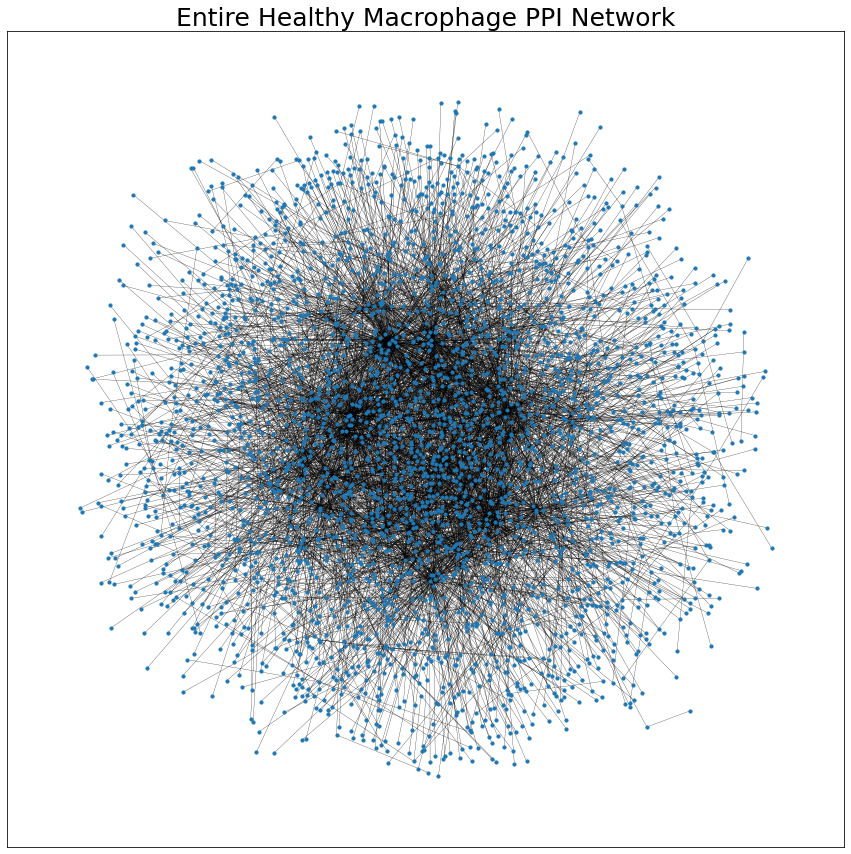

In [37]:
#draw healthy graph

#set fig dimensions
healthy_network, ax = plt.subplots(figsize =(15,15))

#setting x and y coordinates for nodes and edges
pos = nx.spring_layout(G, iterations=20, k = 0.07, seed = 15)

#Draw nodes
nx.draw_networkx_nodes(G,pos, node_size=10)
#Draw Edges        
nx.draw_networkx_edges(G, pos, width=0.25)

#Plot Labels
name = "Entire Healthy Macrophage PPI Network"
plt.title((name), fontdict = {'fontsize': 25, "color":'black'})
plt.show()


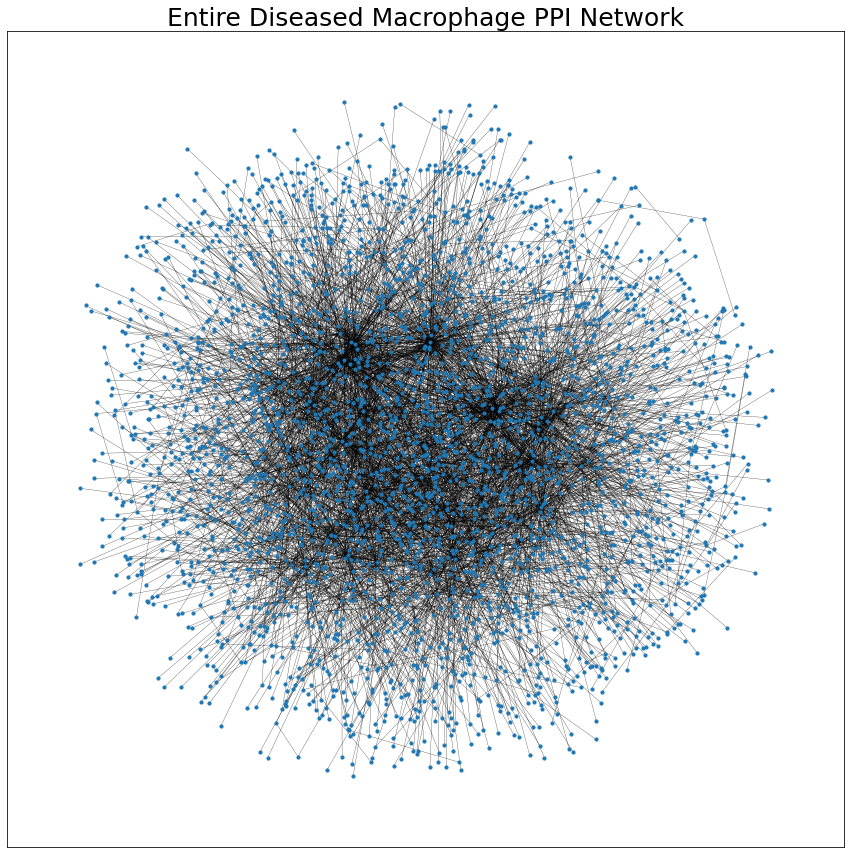

In [38]:
#draw diseased graph

#set fig dimensions
diseased_network, ax = plt.subplots(figsize =(15,15))

#setting x and y coordinates for nodes and edges
pos = nx.spring_layout(GZ, iterations=20, k = 0.07, seed = 15)
#Draw nodes
nx.draw_networkx_nodes(GZ,pos, node_size=10)
#Draw Edges        
nx.draw_networkx_edges(GZ, pos, width=0.25)

#Plot Labels
name = "Entire Diseased Macrophage PPI Network"
plt.title((name), fontdict = {'fontsize': 25, "color":'black'})
plt.show()